# A hastily put together notebook which uses the Maher model to predict the relegated teams of the 2017/18 Premier League.

See https://medium.com/@willmycroft/throwing-darts-at-the-premier-league-table-predicting-the-relegation-zone-via-monte-carlo-fa50aaeba66d

In [13]:
import pandas as pd
import numpy as np
from math import factorial
from itertools import product as cart_product
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [4]:
def log_likelihood(df, alpha, beta, gamma):
    ll = 0
    for index, row in df.iterrows():
        home_lambda = alpha[row.HomeTeam] * beta[row.AwayTeam] * gamma
        away_lambda = alpha[row.AwayTeam] * beta[row.HomeTeam]
        ll += row.FTHG * np.log(home_lambda) - home_lambda - np.log(factorial(row.FTHG))
        ll += row.FTAG * np.log(away_lambda) - away_lambda - np.log(factorial(row.FTAG))
    return ll

def optimise_params(df, threshold = 1e-10):
    alpha, beta = {}, {}
    gamma = 1.0
    for team in df.HomeTeam.unique():
        alpha[team] = 1.0
        beta[team] = 1.0
        
    old = np.zeros(len(alpha)+len(beta)+1)
    while np.abs(np.array(list(alpha.values()) + list(beta.values()) + [gamma]) - old).max() > threshold:
        old = np.array(list(alpha.values()) + list(beta.values()) + [gamma])
        
        denom = 0
        for index, row in df.iterrows():
            denom += alpha[row.HomeTeam]*beta[row.AwayTeam]
        gamma = df.FTHG.sum()/denom
        
        for team in df.HomeTeam.unique():
            away_teams = df[df.HomeTeam == team].AwayTeam
            home_teams = df[df.AwayTeam == team].HomeTeam
            
            alpha[team] = (
                    (df[df.HomeTeam == team].FTHG.sum() + df[df.AwayTeam == team].FTAG.sum()) 
                     /(gamma * np.sum([beta[x] for x in away_teams]) + np.sum([beta[x] for x in home_teams]))
                        )
            beta[team] = (
                    (df[df.AwayTeam == team].FTHG.sum() + df[df.HomeTeam == team].FTAG.sum()) 
                     /(gamma * np.sum([alpha[x] for x in home_teams]) + np.sum([alpha[x] for x in away_teams]))
                        )
    return alpha, beta, gamma

def score_probability(home, away, hg, ag, alpha, beta, gamma):
    home_lambda = alpha[home] * beta[away] * gamma
    away_lambda = alpha[away] * beta[home]
    hg_prob = home_lambda**hg * np.exp(-home_lambda) / factorial(hg)
    ag_prob = away_lambda**ag * np.exp(-away_lambda) / factorial(ag)
    return hg_prob*ag_prob

def predict_game(home, away, alpha, beta, gamma):
    return np.random.poisson(alpha[home]*beta[away]*gamma), np.random.poisson(alpha[away]*beta[home])

def compute_points(df):
    points = dict(zip(df.HomeTeam.unique(), [0]*len(df.HomeTeam.unique())))
    for index, row in df.iterrows():
        if row.FTHG > row.FTAG:
            points[row.HomeTeam] += 3
        elif row.FTHG == row.FTAG:
            points[row.HomeTeam] += 1
            points[row.AwayTeam] += 1
        else:
            points[row.AwayTeam] += 3
    return points

In [5]:
# Load data and fit model
df = pd.read_csv('1718prem.csv')
model = optimise_params(df)
ll = log_likelihood(df, *model)

# Assert that MLE has been found
for team in df.HomeTeam.unique():
    for i in [0,1]:
        model[i][team] += 0.01
        assert(log_likelihood(df, *model) < ll)
        model[i][team] -= 0.02
        assert(log_likelihood(df, *model) < ll)
        model[i][team] += 0.01
    
# Assert scores sum to 1
assert(np.isclose(sum([score_probability('Watford', 'Bournemouth', hg, ag, *model)
            for hg, ag in cart_product(range(100), range(100))]),1))

West Ham win probablity: 0.45511701856444914
Draw probablity: 0.2506162552179004
Southampton win probablity: 0.29426672621764965


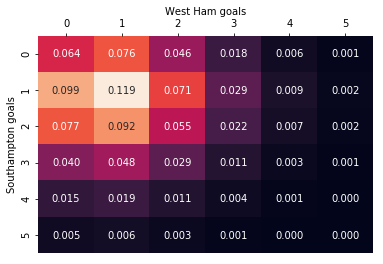

In [14]:
# Predict match
home = 'West Ham'
away = 'Southampton'
max_goals = 50
score_probs = np.zeros((max_goals, max_goals))
for hg, ag in cart_product(range(max_goals), range(max_goals)):
    score_probs[hg, ag] = score_probability(home, away, hg, ag, *model)
plt.figure()

# Compute W,L,D probs
home_win = 0
away_win = 0
for hg, ag in cart_product(range(max_goals), range(max_goals)):
    if hg > ag:
        home_win += score_probs[hg, ag]
    elif hg < ag:
        away_win += score_probs[hg, ag]
    
print(home, 'win probablity:', home_win)
print('Draw probablity:', score_probs.diagonal().sum())
print(away, 'win probablity:', away_win)

# Plot
ax = sns.heatmap(score_probs[:6,:6], annot=True, fmt='.3f', cbar=False)
ax.set_xlabel(home + ' goals')
ax.set_ylabel(away + ' goals')
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()

In [11]:
# Compute remaining fixtures
teams = df.HomeTeam.unique()
matches = list(filter(lambda x: x[0] != x[1], cart_product(teams, teams)))
played = list(zip(df.HomeTeam, df.AwayTeam))
to_play = list(filter(lambda x: x not in played, matches))   

# Perform Monte-Carlo simulation
N = 100
points = compute_points(df)
sorted_teams = sorted(teams, key=lambda x: points[x], reverse=True)
counts = pd.DataFrame(0, columns=['Winner', 'CL', 'Europe', 'Relegated'], index=sorted_teams)
mc_margin = []
for i in range(N):
    data = []
    for home, away in to_play:
        hg, ag = predict_game(home, away, *model)
        data.append([home, away, hg, ag])
    new_results = pd.DataFrame(data, columns=['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG'])
    points = compute_points(df.append(new_results))
    ranking = sorted(points, key=lambda x: points[x], reverse=True)
    counts.Winner[ranking[0]] += 1
    counts.CL[ranking[:4]] += 1
    counts.Europe[ranking[:5]] +=1
    counts.Relegated[ranking[-3:]] += 1
    
print(counts/N)

                Winner    CL  Europe  Relegated
Man City           1.0  1.00    1.00       0.00
Man United         0.0  1.00    1.00       0.00
Liverpool          0.0  0.97    1.00       0.00
Tottenham          0.0  0.90    1.00       0.00
Chelsea            0.0  0.13    0.97       0.00
Arsenal            0.0  0.00    0.03       0.00
Burnley            0.0  0.00    0.00       0.00
Everton            0.0  0.00    0.00       0.00
Leicester          0.0  0.00    0.00       0.00
Watford            0.0  0.00    0.00       0.00
Bournemouth        0.0  0.00    0.00       0.00
Brighton           0.0  0.00    0.00       0.00
Newcastle          0.0  0.00    0.00       0.00
Swansea            0.0  0.00    0.00       0.10
Huddersfield       0.0  0.00    0.00       0.34
Crystal Palace     0.0  0.00    0.00       0.06
West Ham           0.0  0.00    0.00       0.27
Southampton        0.0  0.00    0.00       0.38
Stoke              0.0  0.00    0.00       0.85
West Brom          0.0  0.00    0.00    